In [ ]:
#|default_exp layouts

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
#| export

from clip_plot.utils import timestamp, get_path, write_json, read_json, round_floats, FILE_NAME

import os
from typing import Any
import json
import math
import itertools
from collections import defaultdict
from pathlib import Path

import numpy as np

import operator
import multiprocessing

# TODO: Change math references to numpy

from hdbscan import HDBSCAN
from umap import UMAP, AlignedUMAP

from sklearn.preprocessing import minmax_scale
from scipy.stats import kde

import rasterfairy
from rasterfairy import coonswarp
from pointgrid import align_points_to_grid
import matplotlib.pyplot as plt

## Set some constants we want to remove later

In [ ]:
#| export

## Ignoring cuml-umap for now to avoid conditional import
## We may add cuml-umap option back later
## if profiling shows it may give speedup

## TODO: Profile clip-plot on mnist as worst-case for umap (cheap embeddings, high number of points)

"""
cuML is a suite of fast, GPU-accelerated machine learning algorithms designed for data science and analytical tasks
https://docs.rapids.ai/api/cuml/stable/
"""
cuml_ready = False
cluster_method = "hdbscan"


## Layouts and their inputs

It's useful to think of layouts and the required data to generate them:

### No data:
- alphabetical layout
    - Only requires the total amount of images to generate the layout  
  <br>
  <br>
### Embeddings:
- umap layout
    - Uses embeddings (vecs) to generate layout
    - Under some circumstances it will uses metadata (labels)
- rasterfairy
    - uses umap layout
  <br>
  <br>
### Metadata:
- categorical layout
    - uses "category" data from metadata
- date layout
    - uses "date" data from metadata
- custom layout
    - uses "x" & "y" data from metadata
- geographic layout
    - uses "lat" & "lng" data from metadata
    - Can use a geoJson to create/use custom boundary/map
        - E.g. Replace world map with map of USA
***

## Layouts and their outputs

It's useful to think of layouts and how they output their data (to be consumed by the web application)

All layouts output a .json composed of list of list as follows:
<blockquote>
[<br>
    [<br>
        x, # x-coordinate of 1st image<br> 
        y # y-coordinate of 1st image<br>
    ],<br>
    [<br>
        x, # x-coordinate of 2nd image<br> 
        y # y-coordinate of 2nd image<br>
    ],<br>
    . . . ,<br>
]
</blockquote>

Some layouts will also output a label file specifying labels and their position:
  - Category layouts
  - Date layouts (named "timeline-{plot_id}.json" and "timeline-labels-{plot_id}.json")  
  
<br>  
All layouts (and their label file if applicable) are specified in the manifest.json  <br>

The umap layout is unique in the cense that you can create "variants" by specifying more than one n_neighbors and/or min_dist.  
Clip-plot will generate len(n_neighbors) * len(min_dist) number of variants:  
  - E.g. n_neighbors=[7,15] and min_dist=[.005, .001] will generate 2*2=4 variants  

Each variant is saved as its own file (e.g. "umap-n_neighbors_{n_neighbors_}-min_dist_{min_dist}-{plot_id}.json")  
In addition, each variant (even if there is only one), will have a jittered file saved as well

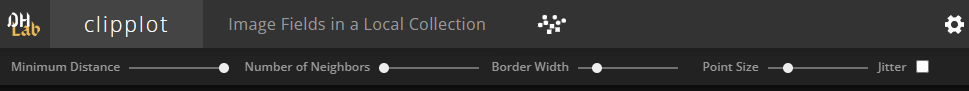
***

# Create layouts based on dimensionality reduction or other

In [ ]:
#| export

def write_layout(path: Path, obj: Any, scale: bool = True, round: bool = True):
    """
    Write layout json `obj` to disk and return the path to the saved file
    """
    if scale:
        # scale -1:1
        obj = (minmax_scale(obj) - 0.5) * 2
    if round:
        obj = round_floats(obj)
    if isinstance(obj, np.ndarray):
        obj = obj.tolist()
    return write_json(path, obj)


In [ ]:
#| export
from abc import ABC, abstractmethod

class BaseLayout(ABC):
    # Hardcoded for each particular layout
    # User should change
    _SCALE = True
    _ROUND = True
    _SUBDIR = "layouts"
    _FILENAME = ""
    _LABEL_FILENAME = ""
    _ADD_HASH = True

    def __init__(self, plot_id, out_dir):
        self.plot_id = plot_id
        self.out_dir = out_dir

    @abstractmethod
    def get_layout(self):
        # Get or create layout
        pass

    def get_path(self, filename=None):
        if filename is None:
            filename = self._FILENAME
        pathDict = {
            "out_dir": self.out_dir}

        return get_path(self._SUBDIR, filename, **pathDict)


class BaseMetaLayout(BaseLayout):
    def __init__(self, plot_id, imageEngine, options={}) -> None:
        super().__init__(plot_id, imageEngine.out_dir)
        self.imageEngine = imageEngine

class AlphabeticLayout(BaseMetaLayout):
    _SUBDIR = "layouts"
    _FILENAME = "grid"

    def get_layout(self):
        """
        Get the x,y positions of images in a grid projection
        """
        print(timestamp(), "Creating grid layout")
        out_path = self.get_path()
        n = math.ceil(self.imageEngine.count ** (1 / 2))
        l = []  # positions
        for i in range(self.imageEngine.count):
            x = i % n
            y = math.floor(i / n)
            l.append([x, y])
        z = np.array(l)

        write_layout(out_path, z)
        return out_path


class CategoricalLayout(BaseMetaLayout):
    DEFAULT_OPTIONS = {
        "null_category": "Other", # No example of different value
        "margin": 2  # No example of different value
    }
    _FILENAME = "categorical"
    _LABEL_FILENAME = "categorical-labels"

    def get_layout(self):
        """
        Return a numpy array with shape (n_points, 2) with the point
        positions of observations in box regions determined by
        each point's category metadata attribute (if applicable)

        Args:
            null_category (Optional[str]='Other')
            margin (Optional[int]=2)
            metadata
        """
        if "category" not in self.imageEngine.meta_headers:
            return False

        print(timestamp(), "Creating categorical layout")
        # determine the out path and return from cache if possible
        out_path = self.get_path()
        labels_out_path = self.get_path("categorical-labels")

        # accumulate d[category] = [indices of points with category]
        categories = [img.metadata.get("category", None) for img in self.imageEngine]
        if not any(categories) or len(set(categories) - set([None])) == 1:
            return False
        d = defaultdict(list)
        for idx, i in enumerate(categories):
            d[i].append(idx)

        # store the number of observations in each group
        keys_and_counts = [{"key": i, "count": len(d[i])} for i in d]
        keys_and_counts.sort(key=operator.itemgetter("count"), reverse=True)
        # get the box layout then subdivide into discrete points
        boxes = get_categorical_boxes([i["count"] for i in keys_and_counts], margin=self.margin)
        points = get_categorical_points(boxes)
        # sort the points into the order of the observations in the metadata
        counts = {i["key"]: 0 for i in keys_and_counts}
        offsets = {i["key"]: 0 for i in keys_and_counts}
        for idx, i in enumerate(keys_and_counts):
            offsets[i["key"]] += sum([j["count"] for j in keys_and_counts[:idx]])
        sorted_points = []
        for img in self.imageEngine:
            category = img.metadata.get("category", self.null_category)
            sorted_points.append(points[offsets[category] + counts[category]])
            counts[category] += 1
        sorted_points = np.array(sorted_points)
        # add to the sorted points the anchors for the text labels for each group
        text_anchors = np.array([[i.x, i.y - self.margin / 2] for i in boxes])
        # add the anchors to the points - these will be removed after the points are projected
        sorted_points = np.vstack([sorted_points, text_anchors])
        # scale -1:1 using the largest axis as the scaling metric
        _max = np.max(sorted_points)
        for i in range(2):
            _min = np.min(sorted_points[:, i])
            sorted_points[:, i] -= _min
            sorted_points[:, i] /= _max - _min
            sorted_points[:, i] -= np.max(sorted_points[:, i]) / 2
            sorted_points[:, i] *= 2
        # separate out the sorted points and text positions
        text_anchors = sorted_points[-len(text_anchors) :]
        sorted_points = sorted_points[: -len(text_anchors)]
        z = round_floats(sorted_points.tolist())
        write_json(out_path, z)
        write_json(labels_out_path,
            {"positions": round_floats(text_anchors.tolist()),
            "labels": [i["key"] for i in keys_and_counts],},
            )
        return {"layout":out_path, "labels": labels_out_path}
    
class CustomLayout(BaseMetaLayout):
    _FILENAME = "custom"

    def get_layout(self):
        """
        Return a 2D array of image positions corresponding to x,y coordinates in metadata
        """
        out_path = self.get_path()
        if not self.imageEngine.metadata:
            return
        found_coords = False
        coords = []
        for i in self.imageEngine:
            x = i.metadata.get("x")
            y = i.metadata.get("y")
            if x and y:
                found_coords = True
                coords.append([x, y])
            else:
                if found_coords:
                    print(
                        timestamp(),
                        "Some images are missing coordinates; skipping custom layout",
                    )
                    return

        if not found_coords:
            return
        else:
            print(timestamp(), "Creating custom layout based on xy coordinates in metadata")
        coords = np.array(coords).astype(float)
        coords = (minmax_scale(coords) - 0.5) * 2
        print(timestamp(), "Creating custom layout")
        write_layout(out_path, coords.tolist())
        return {"layout": out_path}


class GeographicLayout(BaseMetaLayout):
    DEFAULT_OPTIONS = {"geojson": None}
    _FILENAME = "geographic"

    def get_layout(self):
        """Return a 2D array of image positions corresponding to lat, lng coordinates
        Args:
            metadata
            geojson (Union[None,str]): Location of geojson

        Notes:
            Unlike other layouts, does not check first if metadata exists
        """
        print(timestamp(), "Attempt to create geographic layout")

        if "lat" not in self.imageEngine.meta_headers or "lng" not in self.imageEngine.meta_headers:
            return False

        out_path = self.get_path()
        l = []
        coords = False
        for img in self.imageEngine:
            lat = float(img.metadata.get("lat", 0)) / 180
            lng = float(img.metadata.get("lng", 0)) / 180  # the plot draws longitude twice as tall as latitude
            if coords is False and (lat or lng):
                coords = True
            l.append([lng, lat])

        if coords:
            print(timestamp(), "Creating geographic layout")
            write_layout(out_path, l, scale=False)
            return {"layout": out_path}
        elif self.geojson:
            print(
                timestamp(),
                "GeoJSON is only processed if you also provide lat/lng coordinates for your images in a metadata file!",
            )
        return None

In [ ]:
#| export

def get_pointgrid_layout(path, label, *, out_dir: str):
    """Gridify the positions in `path` and return the path to this new layout
    Args:
        path (str)
        label (str)
    """
    print(timestamp(), "Creating {label} pointgrid")
    out_path = get_path("layouts", label + "-jittered", out_dir = out_dir)

    arr = np.array(read_json(path))
    if arr.shape[-1] != 2:
        print(timestamp(), "Could not create pointgrid layout because data is not 2D")
        return None

    z = align_points_to_grid(arr, fill=0.01)
    return write_layout(out_path, z)


In [ ]:
#| export

def get_umap_layout(imageEngine, **kwargs):
    """wraps process_multi_layout_umap
    """
    return process_multi_layout_umap(kwargs["vecs"], imageEngine, **kwargs)


def process_multi_layout_umap(v, imageEngine, **kwargs):
    """Create a multi-layout UMAP projection
    Args:
        v (array like object)
        n_neighbors
        min_dist
        images
    """
    print(timestamp(), "Creating multi-umap layout")
    params = []
    for n_neighbors, min_dist in itertools.product(
        kwargs["n_neighbors"], kwargs["min_dist"]
    ):
        filename = f"umap-n_neighbors_{n_neighbors}-min_dist_{min_dist}"
        out_path = get_path("layouts", filename, out_dir=kwargs["out_dir"])
        params.append(
            {
                "n_neighbors": n_neighbors,
                "min_dist": min_dist,
                FILE_NAME: filename,
                "out_path": out_path,
            }
        )

    singleLayout = len(params) == 1

    # map each image's index to itself and create one copy of that map for each layout
    relations_dict = {idx: idx for idx, _ in enumerate(v)}

    # determine the subset of params that have already been computed
    uncomputed_params = [i for i in params if not os.path.exists(i["out_path"])]

    # Use labels for fitting if available
    y = []
    if "label" in imageEngine.meta_headers:
        labels = [img.metadata.get("label", None) for img in imageEngine]
        # if the user provided labels, integerize them
        if any(i for i in labels):
            d = defaultdict(lambda: len(d))
            for i in labels:
                if i is None:
                    y.append(-1)
                else:
                    y.append(d[i])
            """
            Currently there is no way to have a particular image with the missing field for 
            "label". For scenarios with metadata, If an image is not matched, it is excluded from
            the project.  If the meta value is empty, it will still have "" value .
            """
            y = np.array(y)

        # Fit the model on the data
        if singleLayout is True: # Single layout
            model = get_umap_model(**kwargs)
            z = model.fit(v, y=y if np.any(y) else None).embedding_
            write_layout(params[0]["out_path"], z, **kwargs)

        else:  # Multiple layouts
            model = AlignedUMAP(
                n_neighbors=[i["n_neighbors"] for i in uncomputed_params],
                min_dist=[i["min_dist"] for i in uncomputed_params],
            )
            z = model.fit(
                [v for _ in params], y=[y if np.any(y) else None for _ in params], relations=[relations_dict for _ in params[1:]]
            )
            for idx, i in enumerate(params):
                write_layout(i["out_path"], z.embeddings_[idx], **kwargs)

    # load the list of layout variants
    l = []
    for i in params:
        l.append(
            {
                "n_neighbors": i["n_neighbors"],
                "min_dist": i["min_dist"],
                "layout": i["out_path"],
                "jittered": get_pointgrid_layout(
                    i["out_path"], i[FILE_NAME], out_dir = kwargs["out_dir"]
                ),
            }
        )
    return {
        "variants": l,
    }

def get_umap_model(**kwargs):
    """
    """
    return UMAP(
        n_neighbors=kwargs["n_neighbors"][0],
        min_dist=kwargs["min_dist"][0],
        n_components=kwargs["n_components"],
        metric=kwargs["metric"],
        random_state=kwargs["seed"],
        transform_seed=kwargs["seed"],
    )

In [ ]:
#| export

def get_rasterfairy_layout(**kwargs):
    """Get the x, y position of images passed through a rasterfairy projection

    Args:
        umap: np.ndarray shape (2, n) or maybe (n, 2) not sure

        subfunctions
            get_path()
                *sub_dir (str)
                *filename (str)
                **out_dir (str)
                **add_hash (Optional[bool])
                **plot_id (Optional[str]): Required if add_hash is True
            write_layout()

    """
    print(timestamp(), "Creating rasterfairy layout")
    out_path = get_path("layouts", "rasterfairy", **kwargs)
    umap = np.array(read_json(Path(kwargs["umap"]["variants"][0]["layout"])))
    if umap.shape[-1] != 2:
        print(timestamp(), "Could not create rasterfairy layout because data is not 2D")
        return None
    umap = (umap + 1) / 2  # scale 0:1
    try:
        umap = coonswarp.rectifyCloud(
            umap,  # stretch the distribution
            perimeterSubdivisionSteps=4,
            autoPerimeterOffset=False,
            paddingScale=1.05,
        )
    except Exception as exc:
        print(timestamp(), "Coonswarp rectification could not be performed", exc)
    pos = rasterfairy.transformPointCloud2D(umap)[0]
    return write_layout(out_path, pos, **kwargs)

### Metadata Layout

In [ ]:
#| export

def get_categorical_boxes(group_counts, margin=2):
    """
    @arg [int] group_counts: counts of the number of images in each
      distinct level within the metadata's caetgories
    @kwarg int margin: space between boxes in the 2D layout
    @returns [Box] an array of Box() objects; one per level in `group_counts`
    """
    group_counts = sorted(group_counts, reverse=True)
    boxes = []
    for i in group_counts:
        w = h = math.ceil(i ** (1 / 2))
        boxes.append(Box(i, w, h, None, None))
    # find the position along x axis where we want to create a break
    wrap = math.floor(sum([i.cells for i in boxes]) ** (1 / 2)) - (2 * margin)
    # find the valid positions on the y axis
    y = margin
    y_spots = []
    for i in boxes:
        if (y + i.h + margin) <= wrap:
            y_spots.append(y)
            y += i.h + margin
        else:
            y_spots.append(y)
            break
    # get a list of lists where sublists contain elements at the same y position
    y_spot_index = 0
    for i in boxes:
        # find the y position
        y = y_spots[y_spot_index]
        # find members with this y position
        row_members = [j.x + j.w for j in boxes if j.y == y]
        # assign the y position
        i.y = y
        y_spot_index = (y_spot_index + 1) % len(y_spots)
        # assign the x position
        i.x = max(row_members) + margin if row_members else margin
    return boxes


def get_categorical_points(arr, unit_size=None):
    """Given an array of Box() objects, return a 2D distribution with shape (n_cells, 2)"""
    points_arr = []
    for i in arr:
        area = i.w * i.h
        per_unit = (area / i.cells) ** (1 / 2)
        x_units = math.ceil(i.w / per_unit)
        y_units = math.ceil(i.h / per_unit)
        if not unit_size:
            unit_size = min(i.w / x_units, i.h / y_units)
        for j in range(i.cells):
            x = j % x_units
            y = j // x_units
            points_arr.append(
                [
                    i.x + x * unit_size,
                    i.y + y * unit_size,
                ]
            )
    return np.array(points_arr)


class Box:
    """Store the width, height, and x, y coords of a box"""

    def __init__(self, *args):
        self.cells = args[0]
        self.w = args[1]
        self.h = args[2]
        self.x = None if len(args) < 4 else args[3]
        self.y = None if len(args) < 5 else args[4]

### Geographic Layout

In [ ]:
#| export

def process_geojson(out_dir, geojson_path):
    """Given a GeoJSON filepath, write a minimal JSON output in lat lng coordinates"""
    with open(geojson_path, "r") as f:
        geojson = json.load(f)

    if isinstance(geojson, dict) and "geometry" in geojson:
        geojson = [geojson["geometry"]]

    l = []
    for i in geojson:
        if isinstance(i, dict):
            for j in i.get("coordinates", []):
                for k in j:
                    l.append(k)

    jsonPath = os.path.join(os.path.split(out_dir)[0], "assets", "json", "geographic-features.json")
    with open(jsonPath, "w") as out:
        json.dump(l, out)


### Helpers

In [ ]:
#| export

def get_hotspots(imageEngine, layouts={}, use_high_dimensional_vectors=True, n_preproc_dims=-1,
                 **kwargs):
    """Return the stable clusters from the condensed tree of connected components from the density graph

    Args:
        layouts (Optional[dict] = {}) 
        use_high_dimensional_vectors (Optional[bool] = True) 
        n_preproc_dims
        vecs
        umap = Used if use_high_dimensional_vectors is False
        max_clusters

    """
    print(timestamp(), f"Clustering data with {cluster_method}")
    if use_high_dimensional_vectors:
        vecs = kwargs["vecs"]
    else:
        vecs = read_json(layouts["umap"]["variants"][0]["layout"], **kwargs)

    model = get_cluster_model(**kwargs)
    z = model.fit(vecs)

    # create a map from cluster label to image indices in cluster
    d = defaultdict(lambda: defaultdict(list))
    for idx, i in enumerate(z.labels_):
        if i != -1:
            d[i]["images"].append(idx)
            d[i]["img"] = imageEngine[idx].filename
            d[i]["layout"] = "inception_vectors"

    # remove massive clusters
    deletable = []
    for i in d:
        # find percent of images in cluster
        image_percent = len(d[i]["images"]) / len(vecs)
        # determine if image or area percent is too large
        if image_percent > 0.5:
            deletable.append(i)
    for i in deletable:
        del d[i]

    # sort the clusers by size and then label the clusters
    clusters = d.values()
    clusters = sorted(clusters, key=lambda i: len(i["images"]), reverse=True)
    for idx, i in enumerate(clusters):
        i["label"] = "Cluster {}".format(idx + 1)

    # slice off the first `max_clusters`
    clusters = clusters[: kwargs["max_clusters"]]

    # save the hotspots to disk and return the path to the saved json
    print(timestamp(), "Found", len(clusters), "hotspots")
    return write_json(get_path("hotspots", "hotspot", **kwargs), clusters, **kwargs)


def get_cluster_model(**kwargs):
    """Return a model with .fit() method that can be used to cluster input vectors
    
    Args:
        min_cluster_size

    """
    config = {
        "core_dist_n_jobs": multiprocessing.cpu_count(),
        "min_cluster_size": kwargs["min_cluster_size"],
        "cluster_selection_epsilon": 0.01,
        "min_samples": 1,
        "approx_min_span_tree": False,
    }
    return HDBSCAN(**config)


def get_heightmap(path, label, **kwargs):
    """Create a heightmap using the distribution of points stored at `path`
    Args:
        path
        label
        out_dir
    """

    X = read_json(path, **kwargs)
    if "positions" in X:
        X = X["positions"]
    X = np.array(X)
    if X.shape[-1] != 2:
        print(timestamp(), "Could not create heightmap because data is not 2D")
        return
    # create kernel density estimate of distribution X
    nbins = 200
    x, y = X.T
    xi, yi = np.mgrid[x.min() : x.max() : nbins * 1j, y.min() : y.max() : nbins * 1j]
    zi = kde.gaussian_kde(X.T)(np.vstack([xi.flatten(), yi.flatten()]))
    # create the plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
    fig.subplots_adjust(0, 0, 1, 1)
    plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading="gouraud", cmap=plt.cm.gray)
    plt.axis("off")
    # save the plot
    out_dir = os.path.join(kwargs["out_dir"], "heightmaps")
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    out_path = os.path.join(out_dir, label + "-heightmap.png")
    plt.savefig(out_path, pad_inches=0)


In [ ]:
#| export

##
# Layouts
##


def get_layouts(imageEngine, **kwargs):
    """Get the image positions in each projection"""
    options =  {"geojson": kwargs["geojson"]}

    alphabetic_layout = AlphabeticLayout(kwargs['plot_id'], imageEngine, options)
    categorical_layout = CategoricalLayout(kwargs['plot_id'], imageEngine, options)
    date_layout = DateLayout(kwargs['plot_id'], imageEngine, options)
    custom_layout= CustomLayout(kwargs['plot_id'], imageEngine, options)
    geographic_layout = GeographicLayout(kwargs['plot_id'], imageEngine, options)
    umap = get_umap_layout(imageEngine, **kwargs)
    layouts = {
        "umap": umap,
        "alphabetic": {
            "layout": alphabetic_layout.get_layout(),
        },
        "grid": {
            "layout": get_rasterfairy_layout(umap=umap, **kwargs),
        },
        "categorical": categorical_layout.get_layout(),
        "date": date_layout.get_layout(),
        "geographic": geographic_layout.get_layout(),
        "custom": custom_layout.get_layout(),
    }
    return layouts

In [ ]:
#|hide
import nbdev; nbdev.nbdev_export()